In [133]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

RANDOM_SEED = 42

# Specify each path

In [134]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.h5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [135]:
NUM_CLASSES = 28

# Dataset reading

In [136]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [137]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [139]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7403090268365411, 1: 0.7106427270361697, 2: 1.0213163799551235, 3: 0.9378434065934066, 4: 0.8747597693786034, 5: 0.7913648217907853, 6: 0.823086196503918, 7: 1.2004395604395603, 8: 1.043162719633308, 9: 0.9902102973168962, 10: 1.057297715834301, 11: 1.0459594025277672, 12: 1.0959069020866774, 13: 1.1341362126245846, 14: 0.9609429978888107, 15: 1.0837301587301587, 16: 1.0487711213517665, 17: 0.9492526937782412, 18: 0.931128537333788, 19: 1.0807281361297982, 20: 1.0081210778885197, 21: 1.018649757553152, 22: 1.0459594025277672, 23: 0.8499844382197324, 24: 1.1894599303135889, 25: 1.063059556247567, 26: 1.1308488612836438, 27: 2.9781897491821154}


# Model building

In [140]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [141]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 28)             │           308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378 (5.38 KB)

 Trainable params: 1,378 (5.38 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [143]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [144]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
    class_weight=class_weights_dict
)

Epoch 1/1000
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0524 - loss: 3.2994
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0526 - loss: 3.2987 - val_accuracy: 0.1779 - val_loss: 2.9461
Epoch 2/1000
333/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1362 - loss: 2.8931
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1367 - loss: 2.8899 - val_accuracy: 0.3781 - val_loss: 2.3274
Epoch 3/1000
336/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2089 - loss: 2.5529
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2091 - loss: 2.5517 - val_accuracy: 0.4305 - val_loss: 2.0532
Epoch 4/1000
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2391 - loss: 2.3833
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2392 - loss: 2.3831 - val_accuracy: 0.5445 - val_loss: 1.9138
Epoch 5/1000
335/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2746 - loss: 2.3005
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2746 - loss: 2.3001 - val_accuracy: 0.5934 - val_loss: 1.8075
Epoch 6/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2743 - loss: 2.2609
Epoch 6: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2745 - loss: 2.2596 - val_accuracy: 0.6043 - val_loss: 1.7416
Epoch 7/1000
332/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2970 - loss: 2.1761
Epoch 7: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2970 - loss: 2.1760 - val_accuracy: 0.5527 - val_loss: 1.6788
Epoch 8/1000
324/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3023 - loss: 2.1371
Epoch 8: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3023 - loss: 2.1374 - val_accuracy: 0.6318 - val_loss: 1.6460
Epoch 9/1000
335/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3099 - loss: 2.1245
Epoch 9: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3100 - loss: 2.1242 - val_accuracy: 0.6469 - val_loss: 1.5811
Epoch 10/1000
321/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3175 - loss: 2.0813
Epoch 10: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3175 - loss: 2.0815 - val_accuracy: 0.6749 - val_loss: 1.5684
Epoch 11/1000
335/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3182 - loss: 2.0858
Epoch 11: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3183 - loss: 2.0857 - val_accuracy: 0.6411 - val_loss: 1.5229
Epoch 12/1000
334/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3203 - loss: 2.0856
Epoch 12: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3204 - loss: 2.0851 - val_accuracy: 0.6505 - val_loss: 1.5316
Epoch 13/1000
322/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3191 - loss: 2.0568
Epoch 13: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3195 - loss: 2.0563 - val_accuracy: 0.6571 - val_loss: 1.5108
Epoch 14/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3284 - loss: 2.0186
Epoch 14: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3285 - loss: 2.0185 - val_accuracy: 0.6381 - val_loss: 1.4838
Epoch 15/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3353 - loss: 2.0115
Epoch 15: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3352 - loss: 2.0108 - val_accuracy: 0.6650 - val_loss: 1.4476
Epoch 16/1000
324/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3428 - loss: 2.0068
Epoch 16: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3429 - loss: 2.0053 - val_accuracy: 0.7180 - val_loss: 1.4059
Epoch 17/1000
323/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3488 - loss: 1.9678
Epoch 17: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3487 - loss: 1.9683 - val_accuracy: 0.7100 - val_loss: 1.4132
Epoch 18/1000
325/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3579 - loss: 1.9398
Epoch 18: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3577 - loss: 1.9400 - val_accuracy: 0.7079 - val_loss: 1.3808
Epoch 19/1000
327/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3627 - loss: 1.9296
Epoch 19: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3627 - loss: 1.9296 - val_accuracy: 0.7144 - val_loss: 1.3770
Epoch 20/1000
327/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3690 - loss: 1.9036
Epoch 20: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3687 - loss: 1.9040 - val_accuracy: 0.6903 - val_loss: 1.3454
Epoch 21/1000
324/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3693 - loss: 1.8868
Epoch 21: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3696 - loss: 1.8876 - val_accuracy: 0.7073 - val_loss: 1.3468
Epoch 22/1000
329/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3658 - loss: 1.9210
Epoch 22: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3659 - loss: 1.9203 - val_accuracy: 0.7158 - val_loss: 1.3228
Epoch 23/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3795 - loss: 1.8516
Epoch 23: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3796 - loss: 1.8519 - val_accuracy: 0.6672 - val_loss: 1.3236
Epoch 24/1000
311/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.8578
Epoch 24: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3747 - loss: 1.8587 - val_accuracy: 0.7169 - val_loss: 1.3038
Epoch 25/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3860 - loss: 1.8380
Epoch 25: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3859 - loss: 1.8383 - val_accuracy: 0.7114 - val_loss: 1.2881
Epoch 26/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3821 - loss: 1.8253
Epoch 26: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3824 - loss: 1.8259 - val_accuracy: 0.7172 - val_loss: 1.2762
Epoch 27/1000
329/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3825 - loss: 1.8485
Epoch 27: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3826 - loss: 1.8477 - val_accuracy: 0.7252 - val_loss: 1.2551
Epoch 28/1000
327/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3987 - loss: 1.8071
Epoch 28: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3986 - loss: 1.8076 - val_accuracy: 0.7068 - val_loss: 1.2520
Epoch 29/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3945 - loss: 1.7891
Epoch 29: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3944 - loss: 1.7894 - val_accuracy: 0.7227 - val_loss: 1.2308
Epoch 30/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3983 - loss: 1.8153
Epoch 30: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3982 - loss: 1.8146 - val_accuracy: 0.7087 - val_loss: 1.2440
Epoch 31/1000
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4035 - loss: 1.7769
Epoch 31: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4034 - loss: 1.7769 - val_accuracy: 0.7133 - val_loss: 1.2352
Epoch 32/1000
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3961 - loss: 1.7845
Epoch 32: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3961 - loss: 1.7845 - val_accuracy: 0.6892 - val_loss: 1.2181
Epoch 33/1000
314/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3958 - loss: 1.7710
Epoch 33: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3962 - loss: 1.7713 - val_accuracy: 0.7356 - val_loss: 1.2143
Epoch 34/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4018 - loss: 1.7857
Epoch 34: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4018 - loss: 1.7851 - val_accuracy: 0.7054 - val_loss: 1.1945
Epoch 35/1000
337/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4169 - loss: 1.7418
Epoch 35: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4168 - loss: 1.7418 - val_accuracy: 0.7304 - val_loss: 1.1926
Epoch 36/1000
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4043 - loss: 1.7430
Epoch 36: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4043 - loss: 1.7431 - val_accuracy: 0.7323 - val_loss: 1.1906
Epoch 37/1000
338/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4096 - loss: 1.7561
Epoch 37: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4097 - loss: 1.7559 - val_accuracy: 0.7375 - val_loss: 1.1761
Epoch 38/1000
337/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4161 - loss: 1.7357
Epoch 38: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4160 - loss: 1.7359 - val_accuracy: 0.7026 - val_loss: 1.2013
Epoch 39/1000
332/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4172 - loss: 1.7283
Epoch 39: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4171 - loss: 1.7283 - val_accuracy: 0.7155 - val_loss: 1.1865
Epoch 40/1000
323/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4156 - loss: 1.7358
Epoch 40: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4157 - loss: 1.7357 - val_accuracy: 0.7158 - val_loss: 1.2060
Epoch 41/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4159 - loss: 1.7372
Epoch 41: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4160 - loss: 1.7367 - val_accuracy: 0.7208 - val_loss: 1.1715
Epoch 42/1000
335/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4228 - loss: 1.7140
Epoch 42: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4228 - loss: 1.7141 - val_accuracy: 0.6873 - val_loss: 1.1851
Epoch 43/1000
320/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4167 - loss: 1.6988
Epoch 43: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4169 - loss: 1.6989 - val_accuracy: 0.7133 - val_loss: 1.1714
Epoch 44/1000
313/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4205 - loss: 1.7326
Epoch 44: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4202 - loss: 1.7316 - val_accuracy: 0.7125 - val_loss: 1.1596
Epoch 45/1000
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4171 - loss: 1.7041
Epoch 45: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4172 - loss: 1.7041 - val_accuracy: 0.6944 - val_loss: 1.1875
Epoch 46/1000
299/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4147 - loss: 1.7266
Epoch 46: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4152 - loss: 1.7258 - val_accuracy: 0.7007 - val_loss: 1.1872
Epoch 47/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4313 - loss: 1.7062
Epoch 47: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4308 - loss: 1.7060 - val_accuracy: 0.6884 - val_loss: 1.1712
Epoch 48/1000
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4204 - loss: 1.6816
Epoch 48: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4205 - loss: 1.6817 - val_accuracy: 0.6864 - val_loss: 1.1489
Epoch 49/1000
317/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4203 - loss: 1.7054
Epoch 49: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4208 - loss: 1.7044 - val_accuracy: 0.7348 - val_loss: 1.1539
Epoch 50/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4407 - loss: 1.6870
Epoch 50: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4401 - loss: 1.6878 - val_accuracy: 0.6930 - val_loss: 1.1654
Epoch 51/1000
310/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4259 - loss: 1.6588
Epoch 51: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4258 - loss: 1.6608 - val_accuracy: 0.6900 - val_loss: 1.1743
Epoch 52/1000
318/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4229 - loss: 1.6959
Epoch 52: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4228 - loss: 1.6962 - val_accuracy: 0.7007 - val_loss: 1.1571
Epoch 53/1000
327/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4233 - loss: 1.6939
Epoch 53: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4234 - loss: 1.6933 - val_accuracy: 0.7087 - val_loss: 1.1661
Epoch 54/1000
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.6849
Epoch 54: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4374 - loss: 1.6850 - val_accuracy: 0.7122 - val_loss: 1.1379
Epoch 55/1000
293/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4291 - loss: 1.6646
Epoch 55: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4303 - loss: 1.6640 - val_accuracy: 0.7191 - val_loss: 1.1346
Epoch 56/1000
330/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4318 - loss: 1.6638
Epoch 56: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4318 - loss: 1.6645 - val_accuracy: 0.6700 - val_loss: 1.1967
Epoch 57/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4328 - loss: 1.6670
Epoch 57: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4329 - loss: 1.6671 - val_accuracy: 0.6914 - val_loss: 1.1310
Epoch 58/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4379 - loss: 1.6589
Epoch 58: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4378 - loss: 1.6594 - val_accuracy: 0.7076 - val_loss: 1.1503
Epoch 59/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4459 - loss: 1.6403
Epoch 59: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4458 - loss: 1.6412 - val_accuracy: 0.7103 - val_loss: 1.1261
Epoch 60/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4392 - loss: 1.6653
Epoch 60: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4390 - loss: 1.6653 - val_accuracy: 0.6971 - val_loss: 1.1584
Epoch 61/1000
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4341 - loss: 1.6642
Epoch 61: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4342 - loss: 1.6643 - val_accuracy: 0.7070 - val_loss: 1.1401
Epoch 62/1000
319/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4323 - loss: 1.6777
Epoch 62: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4324 - loss: 1.6775 - val_accuracy: 0.6952 - val_loss: 1.1429
Epoch 63/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4432 - loss: 1.6623
Epoch 63: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4433 - loss: 1.6615 - val_accuracy: 0.6700 - val_loss: 1.1267
Epoch 64/1000
319/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4444 - loss: 1.6499
Epoch 64: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4447 - loss: 1.6496 - val_accuracy: 0.6878 - val_loss: 1.1550
Epoch 65/1000
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4481 - loss: 1.6269
Epoch 65: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4481 - loss: 1.6270 - val_accuracy: 0.6724 - val_loss: 1.1734
Epoch 66/1000
333/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4521 - loss: 1.6301
Epoch 66: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4520 - loss: 1.6304 - val_accuracy: 0.6980 - val_loss: 1.1462
Epoch 67/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4512 - loss: 1.6215
Epoch 67: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4512 - loss: 1.6216 - val_accuracy: 0.6922 - val_loss: 1.1336
Epoch 68/1000
325/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4433 - loss: 1.6347
Epoch 68: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4435 - loss: 1.6345 - val_accuracy: 0.6908 - val_loss: 1.1718
Epoch 69/1000
333/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4517 - loss: 1.6125
Epoch 69: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4518 - loss: 1.6128 - val_accuracy: 0.7068 - val_loss: 1.1169
Epoch 70/1000
321/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4410 - loss: 1.6526
Epoch 70: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4411 - loss: 1.6519 - val_accuracy: 0.6590 - val_loss: 1.1712
Epoch 71/1000
322/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4521 - loss: 1.6396
Epoch 71: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4522 - loss: 1.6381 - val_accuracy: 0.6897 - val_loss: 1.1246
Epoch 72/1000
338/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4527 - loss: 1.6259
Epoch 72: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4527 - loss: 1.6259 - val_accuracy: 0.6771 - val_loss: 1.1748
Epoch 73/1000
320/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4488 - loss: 1.6040
Epoch 73: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4491 - loss: 1.6044 - val_accuracy: 0.6903 - val_loss: 1.1333
Epoch 74/1000
333/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4538 - loss: 1.6321
Epoch 74: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4536 - loss: 1.6319 - val_accuracy: 0.6768 - val_loss: 1.1340
Epoch 75/1000
333/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4564 - loss: 1.6180
Epoch 75: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4564 - loss: 1.6180 - val_accuracy: 0.6779 - val_loss: 1.1373
Epoch 76/1000
328/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4553 - loss: 1.6288
Epoch 76: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4552 - loss: 1.6285 - val_accuracy: 0.6554 - val_loss: 1.1649
Epoch 77/1000
334/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4429 - loss: 1.6169
Epoch 77: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4432 - loss: 1.6170 - val_accuracy: 0.6675 - val_loss: 1.1657
Epoch 78/1000
325/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4522 - loss: 1.6219
Epoch 78: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4524 - loss: 1.6211 - val_accuracy: 0.6604 - val_loss: 1.1502
Epoch 79/1000
331/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4485 - loss: 1.6176
Epoch 79: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4487 - loss: 1.6171 - val_accuracy: 0.6612 - val_loss: 1.1327
Epoch 80/1000
335/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4483 - loss: 1.6135
Epoch 80: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4484 - loss: 1.6136 - val_accuracy: 0.6782 - val_loss: 1.1485
Epoch 81/1000
322/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4511 - loss: 1.5958
Epoch 81: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4515 - loss: 1.5957 - val_accuracy: 0.6938 - val_loss: 1.1303
Epoch 82/1000
330/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4502 - loss: 1.6020
Epoch 82: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4503 - loss: 1.6020 - val_accuracy: 0.6474 - val_loss: 1.1530
Epoch 83/1000
322/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4571 - loss: 1.5873
Epoch 83: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4571 - loss: 1.5879 - val_accuracy: 0.7128 - val_loss: 1.1186
Epoch 84/1000
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4695 - loss: 1.6011
Epoch 84: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4694 - loss: 1.6011 - val_accuracy: 0.6571 - val_loss: 1.1445
Epoch 85/1000
320/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4582 - loss: 1.6186
Epoch 85: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4580 - loss: 1.6175 - val_accuracy: 0.6790 - val_loss: 1.1440
Epoch 86/1000
326/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4642 - loss: 1.5690
Epoch 86: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4642 - loss: 1.5697 - val_accuracy: 0.6612 - val_loss: 1.1744
Epoch 87/1000
314/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4706 - loss: 1.5758
Epoch 87: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4708 - loss: 1.5763 - val_accuracy: 0.6323 - val_loss: 1.1715
Epoch 88/1000
338/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4652 - loss: 1.5826
Epoch 88: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4653 - loss: 1.5824 - val_accuracy: 0.6667 - val_loss: 1.1434
Epoch 89/1000
294/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4673 - loss: 1.5835
Epoch 89: saving model to model/keypoint_classifier/keypoint_classifier.h5


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4674 - loss: 1.5831 - val_accuracy: 0.6625 - val_loss: 1.1548
Epoch 89: early stopping


In [145]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6692 - loss: 1.1604 


In [146]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [147]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[3.5684688e-03 3.3030936e-01 2.2792017e-02 4.6950406e-03 1.4683644e-01
 8.0786072e-02 2.4473846e-03 2.8695893e-06 2.4741716e-05 1.4284405e-02
 1.2512725e-03 3.2287920e-03 2.0101727e-03 4.1506458e-02 4.5804621e-04
 9.1791007e-04 4.0816478e-02 1.9927310e-02 1.4400245e-03 4.8263587e-02
 1.8288776e-02 1.7708029e-01 1.8441720e-02 1.2890127e-05 6.7628702e-05
 2.1763013e-05 9.3905610e-04 1.9580990e-02]
1


# Confusion matrix

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


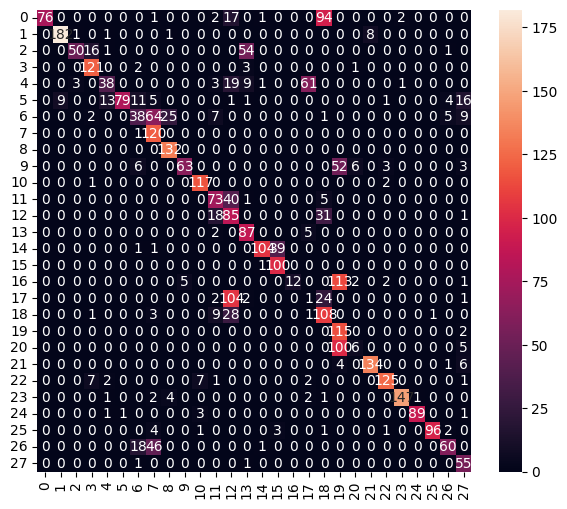

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.39      0.57       193
           1       0.95      0.94      0.95       193
           2       0.93      0.41      0.57       122
           3       0.82      0.95      0.88       127
           4       0.67      0.28      0.40       135
           5       0.99      0.56      0.72       140
           6       0.49      0.25      0.33       151
           7       0.49      0.99      0.65       121
           8       0.81      1.00      0.90       132
           9       0.93      0.47      0.63       133
          10       0.91      0.97      0.94       120
          11       0.62      0.61      0.62       119
          12       0.29      0.63      0.40       135
          13       0.55      0.93      0.69        94
          14       0.96      0.72      0.82       145
          15       0.70      0.99      0.82       101
          16       1.00      0.09      0.16       135
     

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [149]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)
model.export('/home/tingtim/Code/hand-gesture-recognition-mediapipe/model/keypoint_classifier/savedModel')
# tensorflowjs_converter --input_format=keras /home/tingtim/Code/hand-gesture-recognition-mediapipe/model/keypoint_classifier/keypoint_classifier.h5 /home/tingtim/signifai-t/public/models
# tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /home/tingtim/Code/hand-gesture-recognition-mediapipe/model/keypoint_classifier/savedModel /home/tingtim/signifai-t/public/models

INFO:tensorflow:Assets written to: /home/tingtim/Code/hand-gesture-recognition-mediapipe/model/keypoint_classifier/savedModel/assets


INFO:tensorflow:Assets written to: /home/tingtim/Code/hand-gesture-recognition-mediapipe/model/keypoint_classifier/savedModel/assets


Saved artifact at '/home/tingtim/Code/hand-gesture-recognition-mediapipe/model/keypoint_classifier/savedModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  124350051372112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051369232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051373840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051383824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051374416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051376528: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [150]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmprd5qdq6m/assets


INFO:tensorflow:Assets written to: /tmp/tmprd5qdq6m/assets


Saved artifact at '/tmp/tmprd5qdq6m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)
Captures:
  124350051372112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051369232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051373840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051383824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051374416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124350051376528: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1746076312.230429    4775 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746076312.230444    4775 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-01 13:11:52.230601: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprd5qdq6m
2025-05-01 13:11:52.231016: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-01 13:11:52.231023: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmprd5qdq6m
2025-05-01 13:11:52.234651: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-01 13:11:52.258287: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmprd5qdq6m
2025-05-01 13:11:52.265500: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 34901 microseconds.


7628

# Inference test

In [151]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

/home/tingtim/Code/hand-gesture-recognition-mediapipe/hg-envnew/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [152]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [153]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [154]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 0 ns, sys: 88 μs, total: 88 μs
Wall time: 218 μs


In [155]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.5684628e-03 3.3030942e-01 2.2791989e-02 4.6950304e-03 1.4683625e-01
 8.0786079e-02 2.4473814e-03 2.8695870e-06 2.4741577e-05 1.4284419e-02
 1.2512710e-03 3.2287864e-03 2.0101704e-03 4.1506406e-02 4.5804647e-04
 9.1791071e-04 4.0816505e-02 1.9927274e-02 1.4400213e-03 4.8263673e-02
 1.8288806e-02 1.7708051e-01 1.8441698e-02 1.2890056e-05 6.7628251e-05
 2.1762977e-05 9.3905628e-04 1.9581003e-02]
1
